# Work out best moving average crossover

In [39]:
import numpy as np
import pandas as pd
import os
#path = r"C:\Capstone\Data"
#os.chdir(path) 

#load data from CSV file
aud_4h = pd.read_csv("AUD_USD_H4.csv", usecols = [1,2,3,4,5], parse_dates = ['datetime'],
                    dtype={'close':np.float32})
print(aud_4h.shape)
aud_4h.head()

(24477, 5)


,datetime,open,high,low,close
0,2005-01-02 18:00:00+00:00,0.78230,0.78280,0.78060,0.78060
1,2005-01-02 22:00:00+00:00,0.78070,0.78390,0.78070,0.78155
2,2005-01-03 02:00:00+00:00,0.78145,0.78165,0.77265,0.77535
3,2005-01-03 06:00:00+00:00,0.77535,0.77945,0.77315,0.77835
4,2005-01-03 10:00:00+00:00,0.77835,0.78135,0.77615,0.77775


In [40]:
#crate usable date column 

from datetime import datetime
aud_4h['date']= aud_4h['datetime'].apply(lambda x: datetime.strftime(x, '%Y-%m-%d %H:%M'))
aud_4h = aud_4h.drop(columns='datetime')
aud_4h = aud_4h[['date','open', 'high', 'low', 'close']]
aud_4h.head()

,date,open,high,low,close
0,2005-01-02 18:00,0.78230,0.78280,0.78060,0.78060
1,2005-01-02 22:00,0.78070,0.78390,0.78070,0.78155
2,2005-01-03 02:00,0.78145,0.78165,0.77265,0.77535
3,2005-01-03 06:00,0.77535,0.77945,0.77315,0.77835
4,2005-01-03 10:00,0.77835,0.78135,0.77615,0.77775


In [41]:
#define intervals to be searched over

s1 = [10]; s2 = [15]; s3 = [20]
short_intervals = 4*s1 + 4*s2 +4*s3
long_intervals = [30,40,50,60,40,50,60,70,40,50,60,70]

In [42]:
# Calc best combination of short and long SMA

for short, long in zip(short_intervals, long_intervals):
    
    ma_short = aud_4h['close'].rolling(window=short).mean()
    ma_long = aud_4h['close'].rolling(window=long).mean()
    ma_cross = [0]
    
    for i in range(0, len(aud_4h)-1):
        if ma_short[i+1] > ma_long[i+1] and ma_short[i] < ma_long[i]:
            ma_cross.append(1)
        elif ma_short[i+1] < ma_long[i+1] and ma_short[i] > ma_long[i]:
            ma_cross.append(-1)
        else:
            ma_cross.append(0)
        
    buy_trades = []
    sell_trades = []

    for i in range(0, len(aud_4h)-1):
        if ma_cross[i] == 1:
            buy_trades.append((i+1, aud_4h['date'][i+1], aud_4h['open'][i+1]))
        
    for i in range(0, len(aud_4h)-1):
        if ma_cross[i] == -1:
            sell_trades.append((i+1, aud_4h['date'][i+1], aud_4h['open'][i+1]))
                
    sl = 0.0020
    tp = 0.0030
    buy_trades_pnl = []
    sell_trades_pnl = []

    for buy in buy_trades:
        for i in range(buy[0], len(aud_4h)):
            if aud_4h['high'][i] >= buy[2] + tp:
                buy_trades_pnl.append((buy[0],buy[1],'buy ',buy[2],aud_4h['date'][i],aud_4h['high'][i],tp,'t/p hit',i))
                break
            elif aud_4h['low'][i] <= buy[2] - sl:
                buy_trades_pnl.append((buy[0],buy[1],'buy ',buy[2],aud_4h['date'][i],aud_4h['low'][i],-sl,'s/l hit', i))
                break
            elif ma_cross[i] == -1:
                buy_trades_pnl.append((buy[0],buy[1],'buy ',buy[2],aud_4h['date'][i],aud_4h['close'][i],
                                           (aud_4h['close'][i]-buy[2]),'prediction change', i))
                break

    for sell in sell_trades:
        for i in range(sell[0], len(aud_4h)):
            if aud_4h['low'][i] <= sell[2] - tp:
                sell_trades_pnl.append((sell[0],sell[1],'sell',sell[2],aud_4h['date'][i],aud_4h['low'][i],tp,'t/p hit',i))
                break
            elif aud_4h['high'][i] >= sell[2] + sl:
                sell_trades_pnl.append((sell[0],sell[1],'sell',sell[2],aud_4h['date'][i],aud_4h['high'][i],-sl,'s/l hit',i))
                break
            elif ma_cross[i] == 1:
                sell_trades_pnl.append((sell[0],sell[1],'sell',sell[2],aud_4h['date'][i],aud_4h['close'][i],
                                            (sell [2]-aud_4h['close'][i]),'prediction change',i))
                break
                    
    trades = buy_trades_pnl + sell_trades_pnl
    trades.sort()

    good_trades = [trades[0]]
    x = good_trades[0][8]
    for trade in trades:
        if trade[0] > x:
            good_trades.append(trade)
            x = trade[8]

    PnL = sum(x[6] for x in good_trades)         
          
    print(long,'_cross_',short,'Total PnL is:', "{0:.4f}".format(PnL))

30 _cross_ 10 Total PnL is: 0.1342
40 _cross_ 10 Total PnL is: 0.1038
50 _cross_ 10 Total PnL is: 0.0796
60 _cross_ 10 Total PnL is: 0.1264
40 _cross_ 15 Total PnL is: 0.0625
50 _cross_ 15 Total PnL is: 0.1343
60 _cross_ 15 Total PnL is: 0.1547
70 _cross_ 15 Total PnL is: 0.0856
40 _cross_ 20 Total PnL is: 0.2105
50 _cross_ 20 Total PnL is: 0.0682
60 _cross_ 20 Total PnL is: 0.1193
70 _cross_ 20 Total PnL is: 0.1223


In [43]:
# Calc best combination of short and long EMA

import talib as tb
for short, long in zip(short_intervals, long_intervals):
    
    ma_short = tb.EMA(aud_4h['close'], timeperiod=short)
    ma_long = tb.EMA(aud_4h['close'], timeperiod=long)
    ma_cross = [0]
    
    for i in range(0, len(aud_4h)-1):
        if ma_short[i+1] > ma_long[i+1] and ma_short[i] < ma_long[i]:
            ma_cross.append(1)
        elif ma_short[i+1] < ma_long[i+1] and ma_short[i] > ma_long[i]:
            ma_cross.append(-1)
        else:
            ma_cross.append(0)
        
    buy_trades = []
    sell_trades = []

    for i in range(0, len(aud_4h)-1):
        if ma_cross[i] == 1:
            buy_trades.append((i+1, aud_4h['date'][i+1], aud_4h['open'][i+1]))
        
    for i in range(0, len(aud_4h)-1):
        if ma_cross[i] == -1:
            sell_trades.append((i+1, aud_4h['date'][i+1], aud_4h['open'][i+1]))
                
    sl = 0.0020
    tp = 0.0030
    buy_trades_pnl = []
    sell_trades_pnl = []

    for buy in buy_trades:
        for i in range(buy[0], len(aud_4h)):
            if aud_4h['high'][i] >= buy[2] + tp:
                buy_trades_pnl.append((buy[0],buy[1],'buy ',buy[2],aud_4h['date'][i],aud_4h['high'][i],tp,'t/p hit',i))
                break
            elif aud_4h['low'][i] <= buy[2] - sl:
                buy_trades_pnl.append((buy[0],buy[1],'buy ',buy[2],aud_4h['date'][i],aud_4h['low'][i],-sl,'s/l hit', i))
                break
            elif ma_cross[i] == -1:
                buy_trades_pnl.append((buy[0],buy[1],'buy ',buy[2],aud_4h['date'][i],aud_4h['close'][i],
                                           (aud_4h['close'][i]-buy[2]),'prediction change', i))
                break

    for sell in sell_trades:
        for i in range(sell[0], len(aud_4h)):
            if aud_4h['low'][i] <= sell[2] - tp:
                sell_trades_pnl.append((sell[0],sell[1],'sell',sell[2],aud_4h['date'][i],aud_4h['low'][i],tp,'t/p hit',i))
                break
            elif aud_4h['high'][i] >= sell[2] + sl:
                sell_trades_pnl.append((sell[0],sell[1],'sell',sell[2],aud_4h['date'][i],aud_4h['high'][i],-sl,'s/l hit',i))
                break
            elif ma_cross[i] == 1:
                sell_trades_pnl.append((sell[0],sell[1],'sell',sell[2],aud_4h['date'][i],aud_4h['close'][i],
                                            (sell [2]-aud_4h['close'][i]),'prediction change',i))
                break
                    
    trades = buy_trades_pnl + sell_trades_pnl
    trades.sort()

    good_trades = [trades[0]]
    x = good_trades[0][8]
    for trade in trades:
        if trade[0] > x:
            good_trades.append(trade)
            x = trade[8]

    PnL = sum(x[6] for x in good_trades)         
          
    print(long,'_cross_',short,'Total PnL is:', "{0:.4f}".format(PnL))

30 _cross_ 10 Total PnL is: 0.1934
40 _cross_ 10 Total PnL is: 0.2698
50 _cross_ 10 Total PnL is: 0.2312
60 _cross_ 10 Total PnL is: 0.1978
40 _cross_ 15 Total PnL is: 0.1353
50 _cross_ 15 Total PnL is: 0.1473
60 _cross_ 15 Total PnL is: 0.1900
70 _cross_ 15 Total PnL is: 0.1362
40 _cross_ 20 Total PnL is: 0.1506
50 _cross_ 20 Total PnL is: 0.1522
60 _cross_ 20 Total PnL is: 0.0648
70 _cross_ 20 Total PnL is: 0.0720


In [44]:
#add best combinations to dataframe

ma_short = aud_4h['close'].rolling(window=20).mean()
ma_long = aud_4h['close'].rolling(window=40).mean()
ma_cross = [0]
    
for i in range(0, len(aud_4h)-1):
    if ma_short[i+1] > ma_long[i+1] and ma_short[i] < ma_long[i]:
        ma_cross.append(1)
    elif ma_short[i+1] < ma_long[i+1] and ma_short[i] > ma_long[i]:
        ma_cross.append(-1)
    else:
        ma_cross.append(0)
aud_4h['SMA'] = ma_cross
        
ma_short = tb.EMA(aud_4h['close'], timeperiod=10)
ma_long = tb.EMA(aud_4h['close'], timeperiod=40)
ma_cross = [0]
    
for i in range(0, len(aud_4h)-1):
    if ma_short[i+1] > ma_long[i+1] and ma_short[i] < ma_long[i]:
        ma_cross.append(1)
    elif ma_short[i+1] < ma_long[i+1] and ma_short[i] > ma_long[i]:
        ma_cross.append(-1)
    else:
        ma_cross.append(0)
        
aud_4h['EMA'] = ma_cross
aud_4h.head()

,date,open,high,low,close,SMA,EMA
0,2005-01-02 18:00,0.78230,0.78280,0.78060,0.78060,0,0
1,2005-01-02 22:00,0.78070,0.78390,0.78070,0.78155,0,0
2,2005-01-03 02:00,0.78145,0.78165,0.77265,0.77535,0,0
3,2005-01-03 06:00,0.77535,0.77945,0.77315,0.77835,0,0
4,2005-01-03 10:00,0.77835,0.78135,0.77615,0.77775,0,0


# Add indicators to dataset

In [45]:
# calculate 14 period RSI
rsi = tb.RSI(aud_4h['close'], timeperiod=14)
print(rsi.describe(), '\n')

# >70 is the sell signal, <30 is the buy signal
print('Number of times RSI is greater than 70:', rsi[rsi > 70].count())
print('Number of times RSI is less than 30:', rsi[rsi < 30].count())

count    24463.000000
mean        50.421423
std         12.694407
min          6.605515
25%         41.249601
50%         50.711633
75%         59.678735
max         89.342812
dtype: float64 

Number of times RSI is greater than 70: 1446
Number of times RSI is less than 30: 1388


In [46]:
#calculate %B
up, mid, low = tb.BBANDS(aud_4h['close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
bbp = (aud_4h['close'] - low) / (up - low)
print(bbp.describe(), '\n')

# >1 is the sell signal, <0 is the buy signal
print('Number of times %B is greater than 1:', bbp[bbp > 1].count())
print('Number of times %B is less than 0:', bbp[bbp < 0].count())

count    24458.000000
mean         0.510644
std          0.335951
min         -0.468915
25%          0.231520
50%          0.525261
75%          0.786711
max          1.481507
dtype: float64 

Number of times %B is greater than 1: 1458
Number of times %B is less than 0: 1542


In [47]:
#calulate stochastic oscillator
slowk, slowd = tb.STOCH(aud_4h['high'], aud_4h['low'], aud_4h['close'],
                     fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
print(slowk.describe(), '\n')

#> 80 is the overbought or sell signal and < 20 is the buy signal
print('Number of times %K is greater than 80:', slowk[slowk > 80].count())
print('Number of times %K is less than 20:', slowk[slowk < 20].count())

count    24469.000000
mean        50.816904
std         25.358654
min         -0.022220
25%         28.782050
50%         51.368719
75%         72.866425
max        100.015996
dtype: float64 

Number of times %K is greater than 80: 3970
Number of times %K is less than 20: 3572


In [48]:
#calculate MACD or Moving Average Convergence Divergence
macd, macdsignal, macdhist = tb.MACD(aud_4h['close'], fastperiod=12, slowperiod=26, signalperiod=9)
print(macdsignal.describe(), '\n')
print(macd.describe())

count    24444.000000
mean        -0.000023
std          0.002710
min         -0.024557
25%         -0.001449
50%          0.000091
75%          0.001605
max          0.009915
dtype: float64 

count    24444.000000
mean        -0.000022
std          0.002871
min         -0.027788
25%         -0.001547
50%          0.000106
75%          0.001689
max          0.011129
dtype: float64


In [49]:
#calculate Ultimate Oscillater
ultos = tb.ULTOSC(aud_4h['high'], aud_4h['low'], aud_4h['close'], timeperiod1=7, timeperiod2=14, timeperiod3=28)
print(ultos.describe(), '\n')

#> 70 is the overbought or sell signal and < 30 is the buy signal
print('Number of times ultos is greater than 70:', ultos[ultos > 70].count())
print('Number of times ulotos is less than 30:', ultos[ultos < 30].count())

count    24449.000000
mean        50.957860
std          9.949802
min         13.271664
25%         44.199342
50%         50.968874
75%         57.950933
max         87.628048
dtype: float64 

Number of times ultos is greater than 70: 561
Number of times ulotos is less than 30: 413


count    24444.000000
mean        -0.000041
std          0.007256
min         -0.069856
25%         -0.003936
50%          0.000301
75%          0.004150
max          0.038977
dtype: float64


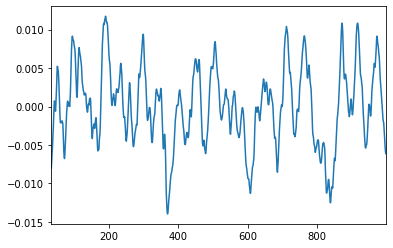

In [50]:
#calculate awesome-oscillator
sma34 = tb.SMA((aud_4h['high']+aud_4h['low'])/2, timeperiod=34)
sma5 = tb.SMA((aud_4h['high']+aud_4h['low'])/2, timeperiod=5)
ao = sma5 - sma34
print(ao.describe())

#plots some values
ao[35:1000].plot()

In [51]:
#create function to add indicators to dataframe
def add_indic(df,indicator, buy_val, sell_val, name):
    indic = []
    for timestamp in indicator:
        if timestamp < buy_val:
            indic.append(1)
        elif timestamp > sell_val:
            indic.append(-1)
        else:
            indic.append(0)
    df[name] = indic

In [52]:
#add momentum indicators to dataframe
add_indic(aud_4h, bbp, 0, 1, '%B')
add_indic(aud_4h, slowk, 20, 80, 'Stoch_Osc')
add_indic(aud_4h, ultos, 30, 70, 'Ult_Osc')
add_indic(aud_4h, rsi, 30, 70, 'RSI')
aud_4h.shape

(24477, 11)

In [53]:
#add awesome oscillator to dataframe
ao_cross = [0]
for i in range(0, len(ao)-1):
    if ao[i+1] > 0 and ao[i] < 0:
        ao_cross.append(1)
    elif ao[i+1] < 0 and ao[i] > 0:
        ao_cross.append(-1)
    else:
        ao_cross.append(0)
        
#add awesome oscillator to dataframe
aud_4h['AO'] = ao_cross

In [54]:
#calculate MACD or Moving Average Convergence Divergence
macd, macdsignal, macdhist = tb.MACD(aud_4h['close'], fastperiod=12, slowperiod=26, signalperiod=9)
print(macdsignal.describe(), '\n')
print(macd.describe())

macd_cross = [0]
for i in range(0, len(macd)-1):
    if macd[i+1] > macdsignal[i+1] and macd[i] < macdsignal[i]:
        macd_cross.append(1)
    elif macd[i+1] < macdsignal[i+1] and macd[i] > macdsignal[i]:
        macd_cross.append(-1)
    else:
        macd_cross.append(0)

aud_4h['MACD'] = macd_cross

count    24444.000000
mean        -0.000023
std          0.002710
min         -0.024557
25%         -0.001449
50%          0.000091
75%          0.001605
max          0.009915
dtype: float64 

count    24444.000000
mean        -0.000022
std          0.002871
min         -0.027788
25%         -0.001547
50%          0.000106
75%          0.001689
max          0.011129
dtype: float64


In [55]:
#add target variable
l = []
diff = aud_4h['close'].diff()
for i in diff:
    if i > 0.0020:
        l.append(1)
    elif i < -0.0020:
        l.append(-1)
    else:
        l.append(0)
    
aud_4h['target'] = l
aud_4h.head()

,date,open,high,low,close,SMA,EMA,%B,Stoch_Osc,Ult_Osc,RSI,AO,MACD,target
0,2005-01-02 18:00,0.78230,0.78280,0.78060,0.78060,0,0,0,0,0,0,0,0,0
1,2005-01-02 22:00,0.78070,0.78390,0.78070,0.78155,0,0,0,0,0,0,0,0,0
2,2005-01-03 02:00,0.78145,0.78165,0.77265,0.77535,0,0,0,0,0,0,0,0,-1
3,2005-01-03 06:00,0.77535,0.77945,0.77315,0.77835,0,0,0,0,0,0,0,0,1
4,2005-01-03 10:00,0.77835,0.78135,0.77615,0.77775,0,0,0,0,0,0,0,0,0


In [56]:
aud_4h = aud_4h.drop(columns= ['open', 'high', 'low', 'date'])
aud_4h

,close,SMA,EMA,%B,Stoch_Osc,Ult_Osc,RSI,AO,MACD,target
0,0.78060,0,0,0,0,0,0,0,0,0
1,0.78155,0,0,0,0,0,0,0,0,0
2,0.77535,0,0,0,0,0,0,0,0,-1
3,0.77835,0,0,0,0,0,0,0,0,1
4,0.77775,0,0,0,0,0,0,0,0,0
5,0.77875,0,0,0,0,0,0,0,0,0
6,0.77835,0,0,0,0,0,0,0,0,0
7,0.77665,0,0,0,0,0,0,0,0,0
8,0.77995,0,0,0,0,0,0,0,0,1
9,0.77380,0,0,0,0,0,0,0,0,-1


# Train and Test Split

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
#from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score, classification_report

#splt data into training and testing
split = int(0.8*len(aud_4h))
X_cols = aud_4h.loc[:, aud_4h.columns != 'target']
#X_cols = X_cols.loc[:, X_cols.columns != 'date']
Y_cols = aud_4h['target']

# Split X and y 
X_train = X_cols[:split]
X_test = X_cols[split:]
y_train = Y_cols[:split]
y_test = Y_cols[split:]
 
print(len(X_train),len(y_train),len(X_test),len(y_test))

19581 19581 4896 4896


In [58]:
#create base model
rand_frst_clf = RandomForestClassifier(n_estimators = 600, oob_score = True, criterion = "gini",
                                       random_state = 0, bootstrap = True, max_depth = 100, max_features = "auto",
                                       min_samples_leaf = 2, min_samples_split = 10)
rand_frst_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=100, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=None, oob_score=True, random_state=0, verbose=0,
                       warm_start=False)

In [59]:
#accuracy with base line model
y_pred = rand_frst_clf.predict(X_test)
accuracy_score(y_test, y_pred,  sample_weight=None)

0.7467320261437909

In [60]:
#print feature importance for base model
feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_cols.columns).sort_values(ascending=False)
feature_imp

close        0.680575
%B           0.174628
MACD         0.051514
Stoch_Osc    0.033672
RSI          0.022028
EMA          0.012385
AO           0.008618
Ult_Osc      0.008439
SMA          0.008140
dtype: float64

In [61]:
print(classification_report(y_test, y_pred,  sample_weight=None))

              precision    recall  f1-score   support

          -1       0.28      0.28      0.28       388
           0       0.87      0.83      0.85      4151
           1       0.20      0.32      0.25       357

    accuracy                           0.75      4896
   macro avg       0.45      0.48      0.46      4896
weighted avg       0.77      0.75      0.76      4896



In [62]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


# Training the model

In [63]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 25.6min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [64]:
#print best parameters of tuned model
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 400}

In [65]:
#accuracy after hyperparameter tuning
y_pred = rf_random.predict(X_test)
accuracy_score(y_test, y_pred,  sample_weight=None)

0.8157679738562091

In [66]:
#print feature importance for tuned model
feature_imp = pd.Series(rf_random.best_estimator_.feature_importances_, index=X_cols.columns).sort_values(ascending=False)
feature_imp

%B           0.466786
close        0.244449
MACD         0.127962
Stoch_Osc    0.073696
RSI          0.044484
EMA          0.020417
Ult_Osc      0.011025
AO           0.006814
SMA          0.004366
dtype: float64

In [67]:
print(classification_report(y_test, y_pred,  sample_weight=None))

              precision    recall  f1-score   support

          -1       0.36      0.26      0.30       388
           0       0.87      0.92      0.89      4151
           1       0.34      0.25      0.29       357

    accuracy                           0.82      4896
   macro avg       0.53      0.47      0.49      4896
weighted avg       0.79      0.82      0.80      4896



# Load the testing data

In [68]:
#load backtesting data from CSV file
aud_4h_test = pd.read_csv("AUD_USD_4H_new.csv", usecols = [0,1,2,3,4], parse_dates = ['datetime'], dtype={'close':np.float32})
aud_4h_test['date']= aud_4h_test['datetime'].apply(lambda x: datetime.strftime(x, '%Y-%m-%d %H:%M'))
aud_4h_test = aud_4h_test.drop(columns='datetime')
print(aud_4h_test.shape, aud_4h.shape, )
aud_4h_test.head()

(584, 5) (24477, 10)


,open,high,low,close,date
0,0.7021,0.7021,0.7016,0.7016,2020-01-01 09:00
1,0.7024,0.7024,0.7006,0.7007,2020-02-01 01:00
2,0.7013,0.7019,0.7011,0.7017,2020-02-01 05:00
3,0.7017,0.7020,0.7006,0.7016,2020-02-01 09:00
4,0.7016,0.7019,0.6995,0.7002,2020-02-01 13:00


In [69]:
#add indicators to create back testing dataset

ma_short = aud_4h_test['close'].rolling(window=20).mean()
ma_long = aud_4h_test['close'].rolling(window=40).mean()
ma_cross = [0]
    
for i in range(0, len(aud_4h_test)-1):
    if ma_short[i+1] > ma_long[i+1] and ma_short[i] < ma_long[i]:
        ma_cross.append(1)
    elif ma_short[i+1] < ma_long[i+1] and ma_short[i] > ma_long[i]:
        ma_cross.append(-1)
    else:
        ma_cross.append(0)
aud_4h_test['SMA'] = ma_cross
        
ma_short = tb.EMA(aud_4h_test['close'], timeperiod=10)
ma_long = tb.EMA(aud_4h_test['close'], timeperiod=40)
ma_cross = [0]
    
for i in range(0, len(aud_4h_test)-1):
    if ma_short[i+1] > ma_long[i+1] and ma_short[i] < ma_long[i]:
        ma_cross.append(1)
    elif ma_short[i+1] < ma_long[i+1] and ma_short[i] > ma_long[i]:
        ma_cross.append(-1)
    else:
        ma_cross.append(0)
        
aud_4h_test['EMA'] = ma_cross

rsi = tb.RSI(aud_4h_test['close'], timeperiod=14)
up, mid, low = tb.BBANDS(aud_4h_test['close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
bbp = (aud_4h_test['close'] - low) / (up - low)
slowk, slowd = tb.STOCH(aud_4h_test['high'], aud_4h_test['low'], aud_4h_test['close'],
                     fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
macd, macdsignal, macdhist = tb.MACD(aud_4h_test['close'], fastperiod=12, slowperiod=26, signalperiod=9)
ultos = tb.ULTOSC(aud_4h_test['high'], aud_4h_test['low'], aud_4h_test['close'], timeperiod1=7, timeperiod2=14, timeperiod3=28)
sma34 = tb.SMA((aud_4h_test['high']+aud_4h_test['low'])/2, timeperiod=34)
sma5 = tb.SMA((aud_4h_test['high']+aud_4h_test['low'])/2, timeperiod=5)
ao = sma5 - sma34

add_indic(aud_4h_test, bbp, 0, 1, '%B')
add_indic(aud_4h_test, slowk, 20, 80, 'Stoch_Osc')
add_indic(aud_4h_test, ultos, 30, 70, 'Ult_Osc')
add_indic(aud_4h_test, rsi, 30, 70, 'RSI')

ao_cross = [0]
for i in range(0, len(ao)-1):
    if ao[i+1] > 0 and ao[i] < 0:
        ao_cross.append(1)
    elif ao[i+1] < 0 and ao[i] > 0:
        ao_cross.append(-1)
    else:
        ao_cross.append(0)
        
aud_4h_test['AO'] = ao_cross

macd_cross = [0]
for i in range(0, len(macd)-1):
    if macd[i+1] > macdsignal[i+1] and macd[i] < macdsignal[i]:
        macd_cross.append(1)
    elif macd[i+1] < macdsignal[i+1] and macd[i] > macdsignal[i]:
        macd_cross.append(-1)
    else:
        macd_cross.append(0)

aud_4h_test['MACD'] = macd_cross

print(aud_4h_test.shape)
aud_4h_test.head()

(584, 13)


,open,high,low,close,date,SMA,EMA,%B,Stoch_Osc,Ult_Osc,RSI,AO,MACD
0,0.7021,0.7021,0.7016,0.7016,2020-01-01 09:00,0,0,0,0,0,0,0,0
1,0.7024,0.7024,0.7006,0.7007,2020-02-01 01:00,0,0,0,0,0,0,0,0
2,0.7013,0.7019,0.7011,0.7017,2020-02-01 05:00,0,0,0,0,0,0,0,0
3,0.7017,0.7020,0.7006,0.7016,2020-02-01 09:00,0,0,0,0,0,0,0,0
4,0.7016,0.7019,0.6995,0.7002,2020-02-01 13:00,0,0,0,0,0,0,0,0


In [70]:
#Drop first 40 rows as MA data does not start until row 40

from datetime import datetime
aud_4h_test = aud_4h_test[40:].reset_index(drop=True)
aud_4h_to_pred = aud_4h_test.drop(columns=['open', 'high', 'low', 'date'])
aud_4h_to_pred.head()

,close,SMA,EMA,%B,Stoch_Osc,Ult_Osc,RSI,AO,MACD
0,0.6855,0,0,0,1,0,0,0,0
1,0.6879,0,0,0,0,0,0,0,0
2,0.6876,0,0,0,0,0,0,0,0
3,0.6879,0,0,0,-1,0,0,0,0
4,0.6906,0,0,-1,0,0,0,0,0


In [71]:
#create final dataset for backtesting

Predictions = rf_random.predict(aud_4h_to_pred)
print(aud_4h_test.shape, Predictions.shape)
aud_final = aud_4h_test
aud_final['preds'] = Predictions
aud_final.head()

(544, 13) (544,)


,open,high,low,close,date,SMA,EMA,%B,Stoch_Osc,Ult_Osc,RSI,AO,MACD,preds
0,0.6858,0.6871,0.6851,0.6855,2020-10-01 09:00,0,0,0,1,0,0,0,0,-1
1,0.6855,0.6880,0.6854,0.6879,2020-10-01 13:00,0,0,0,0,0,0,0,0,0
2,0.6879,0.6883,0.6870,0.6876,2020-10-01 17:00,0,0,0,0,0,0,0,0,0
3,0.6876,0.6892,0.6873,0.6879,2020-10-01 21:00,0,0,0,-1,0,0,0,0,0
4,0.6879,0.6911,0.6877,0.6906,2020-11-01 01:00,0,0,-1,0,0,0,0,0,1


In [72]:
#find trades executed by prediction model, IE sell when -1 and buy when +1

buy_trades = []
sell_trades = []

for i in range(0, len(aud_final)-1):
    if aud_final['preds'][i] == 1:
        buy_trades.append((i+1, aud_final['date'][i+1], aud_final['open'][i+1]))
        
for i in range(0, len(aud_final)-1):
    if aud_final['preds'][i] == -1:
        sell_trades.append((i+1, aud_final['date'][i+1], aud_final['open'][i+1]))

# Run the backtest strategy

In [73]:
"""Loop over combinations of SL/TP paramaters. Here we close the position if the prediction changed before SL or TP hit. 
No trade can be initiiated before the previous one has been closed
Otherwise the magrin required by the CFD provider increases"""

best = []
sl_s = [0.0020, 0.0030, 0.0030, 0.0040, 0.0050]
tp_s = [0.0030, 0.0040, 0.0050, 0.0060, 0.0075]
for sl, tp in zip(sl_s, tp_s):
    
    buy_trades_pnl = []
    sell_trades_pnl = []

    for buy in buy_trades:
        for i in range(buy[0], len(aud_final)):
            if aud_final['high'][i] >= buy[2] + tp:
                buy_trades_pnl.append((buy[0],buy[1],'buy ',buy[2],aud_final['date'][i],aud_final['high'][i],tp,'t/p hit',i))
                break
            elif aud_final['low'][i] <= buy[2] - sl:
                buy_trades_pnl.append((buy[0],buy[1],'buy ',buy[2],aud_final['date'][i],aud_final['low'][i],-sl,'s/l hit', i))
                break
            elif aud_final['preds'][i] == -1:
                buy_trades_pnl.append((buy[0],buy[1],'buy ',buy[2],aud_final['date'][i],aud_final['close'][i],
                                   (aud_final['close'][i]-buy[2]),'prediction change', i))
                break

    for sell in sell_trades:
        for i in range(sell[0], len(aud_final)):
            if aud_final['low'][i] <= sell[2] - tp:
                sell_trades_pnl.append((sell[0],sell[1],'sell',sell[2],aud_final['date'][i],aud_final['low'][i],tp,'t/p hit',i))
                break
            elif aud_final['high'][i] >= sell[2] + sl:
                sell_trades_pnl.append((sell[0],sell[1],'sell',sell[2],aud_final['date'][i],aud_final['high'][i],-sl,'s/l hit',i))
                break
            elif aud_final['preds'][i] == 1:
                sell_trades_pnl.append((sell[0],sell[1],'sell',sell[2],aud_final['date'][i],aud_final['close'][i],
                                    (sell [2]-aud_final['close'][i]),'prediction change',i))
                break
                
    trades = buy_trades_pnl + sell_trades_pnl
    trades.sort()

    good_trades = [trades[0]]
    x = good_trades[0][8]
    for trade in trades:
        if trade[0] > x:
            good_trades.append(trade)
            x = trade[8]

    PnL = sum(x[6] for x in good_trades) 
    best.append((PnL,tp, sl))

    print('Total PnL is:', "{0:.4f}".format(PnL), 'stop-loss:', sl, 'take-profit:', tp,',', len(good_trades), 'trades')
    
best.sort(reverse=True)
print('\nThe best combination of t/p and s/l is --> take-profit:', best[0][1], 'stop-loss:', best[0][2])

Total PnL is: 0.0640 stop-loss: 0.002 take-profit: 0.003 , 205 trades
Total PnL is: 0.0248 stop-loss: 0.003 take-profit: 0.004 , 171 trades
Total PnL is: 0.0227 stop-loss: 0.003 take-profit: 0.005 , 159 trades
Total PnL is: 0.0562 stop-loss: 0.004 take-profit: 0.006 , 129 trades
Total PnL is: 0.0161 stop-loss: 0.005 take-profit: 0.0075 , 112 trades

The best combination of t/p and s/l is --> take-profit: 0.003 stop-loss: 0.002


# Detailed output of the trades made

In [74]:
#return trades for best combination

sl = best[0][2]
tp = best[0][1]
    
buy_trades_pnl = []
sell_trades_pnl = []

for buy in buy_trades:
    for i in range(buy[0], len(aud_final)):
        if aud_final['high'][i] >= buy[2] + tp:
            buy_trades_pnl.append((buy[0],buy[1],'buy ',buy[2],aud_final['date'][i],aud_final['high'][i],tp,'t/p hit',i))
            break
        elif aud_final['low'][i] <= buy[2] - sl:
            buy_trades_pnl.append((buy[0],buy[1],'buy ',buy[2],aud_final['date'][i],aud_final['low'][i],-sl,'s/l hit', i))
            break
        elif aud_final['preds'][i] == -1:
            buy_trades_pnl.append((buy[0],buy[1],'buy ',buy[2],aud_final['date'][i],aud_final['close'][i],
                                   (aud_final['close'][i]-buy[2]),'prediction change', i))
            break

for sell in sell_trades:
    for i in range(sell[0], len(aud_final)):
        if aud_final['low'][i] <= sell[2] - tp:
            sell_trades_pnl.append((sell[0],sell[1],'sell',sell[2],aud_final['date'][i],aud_final['low'][i],tp,'t/p hit',i))
            break
        elif aud_final['high'][i] >= sell[2] + sl:
            sell_trades_pnl.append((sell[0],sell[1],'sell',sell[2],aud_final['date'][i],aud_final['high'][i],-sl,'s/l hit',i))
            break
        elif aud_final['preds'][i] == 1:
            sell_trades_pnl.append((sell[0],sell[1],'sell',sell[2],aud_final['date'][i],aud_final['close'][i],
                                    (sell [2]-aud_final['close'][i]),'prediction change',i))
            break
                
trades = buy_trades_pnl + sell_trades_pnl
trades.sort()

good_trades = [trades[0]]
x = good_trades[0][8]
for trade in trades:
    if trade[0] > x:
        good_trades.append(trade)
        x = trade[8]

PnL = sum(x[6] for x in good_trades)
best.append((PnL,tp, sl))

print('  Entry date   ', '     B/S', '   Entry price', '      Exit date  ', '        Exit price', 
      '   PnL  ', '      Comment','\n')
for trade in good_trades:
    print("{:20}".format(trade[1]),trade[2],'    ',"{:.4f}".format(trade[3]),'    ',"{:20}".format(trade[4]),'   ',
          "{:.4f}".format(trade[5]),'   ',"{:.4f}".format(trade[6]),'    ',trade[7])
    
print('\nTotal PnL is:', "{0:.4f}".format(PnL))
print('Totoal Number of Trades is:', len(good_trades))

  Entry date         B/S    Entry price       Exit date           Exit price    PnL         Comment 

2020-10-01 13:00     sell      0.6855      2020-10-01 13:00         0.6880     -0.0020      s/l hit
2020-11-01 05:00     buy       0.6906      2020-01-13 05:00         0.6882     -0.0020      s/l hit
2020-01-13 13:00     buy       0.6912      2020-01-14 09:00         0.6885     -0.0020      s/l hit
2020-01-16 01:00     sell      0.6885      2020-01-16 01:00         0.6917     -0.0020      s/l hit
2020-01-16 05:00     buy       0.6910      2020-01-17 01:00         0.6888     -0.0020      s/l hit
2020-01-17 13:00     sell      0.6895      2020-01-20 21:00         0.6859     0.0030      t/p hit
2020-01-22 13:00     sell      0.6832      2020-01-22 21:00         0.6856     -0.0020      s/l hit
2020-01-25 05:00     sell      0.6824      2020-01-27 17:00         0.6771     0.0030      t/p hit
2020-01-27 21:00     sell      0.6776      2020-01-28 17:00         0.6737     0.0030      t/p hit
2